In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from datetime import datetime, date
import warnings
import gc  
import importlib
from pathlib import Path
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder, PolynomialFeatures
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, mean_squared_log_error
from sklearn.decomposition import PCA
from sklearn.linear_model import Ridge, Lasso, ElasticNet, LinearRegression
from sklearn.ensemble import (
    RandomForestRegressor,
    GradientBoostingRegressor,
    StackingRegressor,
    ExtraTreesRegressor,
    AdaBoostRegressor
)
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

from sklearn.preprocessing import LabelEncoder
import pickle  
import external_data.example_estimator  # For external data processing
importlib.reload(external_data.example_estimator)
%matplotlib inline
pd.pandas.set_option('display.max_columns', None)
from sklearn.cluster import KMeans


In [ ]:
!pip install geopy
from geopy.distance import distance


We are starting by loading the train and test data. 
We then use functions from example_estimator file to merge with weather data and encode the dates.

In [ ]:
# Data paths
data_path = 'data/train.parquet'
test_path = 'data/final_test.parquet'

train_data = pd.read_parquet(Path(data_path))
print(train_data.columns)
test_data = pd.read_parquet(Path(test_path))

train_data = external_data.example_estimator._encode_dates(train_data)
train_data = external_data.example_estimator._merge_external_data(train_data)

Now,
Let us create a set of features that can be derived from the data that we have

In [ ]:
# We have a column weekday, we create a column is_weekend.
# On weekends, the trend of bike users might be different and this feature can help us capture it
train_data['is_weekend'] = train_data['weekday'].isin([5, 6]).astype(int)


# Since Paris is a big city, the traffic and use of bikes can be different as we move towards 
# and away fro city centre. To capture this we modelled 
city_center = (48.8566, 2.3522)  # Coordinates of Paris city center distance_to_center
train_data['distance_to_center'] = train_data.apply(
    lambda row: distance(city_center, (row['latitude'], row['longitude'])).km,
    axis=1
)

In [ ]:
# Let us now derive some features from the weather data that we had
train_data['is_rainy'] = (train_data['rr1'] > 0).astype(int)
train_data['is_windy'] = (train_data['ff'] > 8).astype(int)
train_data['low_visibility'] = (train_data['vv'] < 1000).astype(int)

# Temperature related features
train_data['temperature_c'] = train_data['t'] - 273.15  
train_data['is_hot'] = (train_data['temperature_c'] > 20).astype(int)  # Hot weather indicator
train_data['is_cold'] = (train_data['temperature_c'] < 5).astype(int)  # Cold weather indicator
train_data['is_snowy'] = (train_data['temperature_c'] < 0).astype(int)  # Snowy weather indicator

In [ ]:
# Different periods of days can have different traffics,  
# hence we created bins 'Night', 'Morning', 'Afternoon', 'Evening'
train_data['day_period'] = pd.cut(
    train_data['hour'], 
    bins=[0, 6, 12, 18, 24],  
    labels=['Night', 'Morning', 'Afternoon', 'Evening'],  
    right=False  
)

train_data.rename(columns={
    'workday': 'workingday',
    'temperature_c': 'temp',  
    'u': 'humidity',  
    'ff': 'windspeed'  
}, inplace=True)


# atemp is actually what the temperature feels like.
# Wind can make it feel even colder
if 'atemp' not in train_data.columns:
    train_data['atemp'] = np.where(train_data['is_windy'] == 1, train_data['temp'] - 2, train_data['temp'])

# Deriving week number
if 'week' not in train_data.columns:
    train_data['week'] = pd.to_datetime(train_data['date']).dt.isocalendar().week  

# weather feature gives the class of what weather it is based on the features we made.
# This feature incorporates information of snow and rain we calculated earlier
if 'weather' not in train_data.columns:
    conditions = [
        (train_data['is_rainy'] == 1),
        (train_data['is_snowy'] == 1)
    ]
    choices = ['Rainy', 'Snowy']
    train_data['weather'] = np.select(conditions, choices, default='Clear')

In [ ]:
# Hours and months are continous data and these components can be very crucial.
# We capture them using sin and cos functions
train_data['sin_hour'] = np.sin(train_data['hour'] * (2 * np.pi / 24))
train_data['cos_hour'] = np.cos(train_data['hour'] * (2 * np.pi / 24))
train_data['sin_month'] = np.sin(train_data['month'] * (2 * np.pi / 12))
train_data['cos_month'] = np.cos(train_data['month'] * (2 * np.pi / 12))

In [ ]:
final_train_data = train_data
print(final_train_data.head())

**External data**

Vacations in Paris can be a very crucial factor in determining the bike count
We have used an external dataset vacances_paris.csv

**Source and Liscence:**

Source: https://www.data.gouv.fr/fr/datasets/le-calendrier-scolaire/

Liscence: Licence Ouverte / Open Licence version 2.0


In [7]:

holidays = pd.read_csv("data/vacances_paris.csv")

In [102]:
holidays.head(5)

,Unnamed: 0,Description,Population,Date de début,Date de fin,Académies,Zones,annee_scolaire
0,222,Vacances de Noël,-,2017-12-22T23:00:00+00:00,2018-01-07T23:00:00+00:00,Paris,Zone C,2017-2018
1,230,Vacances de Noël,-,2018-12-21T23:00:00+00:00,2019-01-06T23:00:00+00:00,Paris,Zone C,2018-2019
2,245,Pont de l'Ascension,-,2020-05-19T22:00:00+00:00,2020-05-24T22:00:00+00:00,Paris,Zone C,2019-2020
3,248,Vacances de Noël,-,2020-12-18T23:00:00+00:00,2021-01-03T23:00:00+00:00,Paris,Zone C,2020-2021
4,257,Vacances d'Été,Élèves,2021-07-05T22:00:00+00:00,2021-09-01T22:00:00+00:00,Paris,Zone C,2020-2021


In [51]:

# Now let us incorporate the holiday information of schools into our data
holidays["Start_Date"] = pd.to_datetime(holidays["Date de début"]).dt.tz_localize(None)
holidays["End_Date"] = pd.to_datetime(holidays["Date de fin"]).dt.tz_localize(None)

final_train_data["date"] = pd.to_datetime(final_train_data["date"]).dt.tz_localize(None)

def is_school_holiday_vectorized(dates, holidays):
    is_holiday = [0] * len(dates)

    for _, row in holidays.iterrows():
        is_holiday = is_holiday | ((dates >= row["Start_Date"]) & (dates <= row["End_Date"])).astype(int)
    
    return is_holiday

final_train_data["school_holiday"] = is_school_holiday_vectorized(final_train_data["date"], holidays)

final_train_data.head(5)


/var/folders/tc/ddy9q3l50gv9sy77lbp_p_cr0000gn/T/ipykernel_22487/2058138871.py:10: FutureWarning: Logical ops (and, or, xor) between Pandas objects and dtype-less sequences (e.g. list, tuple) are deprecated and will raise in a future version. Wrap the object in a Series, Index, or np.array before operating instead.
  is_holiday = is_holiday | ((dates >= row["Start_Date"]) & (dates <= row["End_Date"])).astype(int)


,counter_id,counter_name,site_id,site_name,bike_count,date,counter_installation_date,coordinates,counter_technical_id,latitude,longitude,log_bike_count,year,month,day,weekday,hour,holiday,week_of_month,workingday,season,numer_sta,pmer,tend,cod_tend,dd,windspeed,t,td,humidity,vv,ww,w1,w2,n,nbas,hbas,cl,cm,ch,pres,niv_bar,geop,tend24,tn12,tn24,tx12,tx24,tminsol,sw,tw,raf10,rafper,per,etat_sol,ht_neige,ssfrai,perssfrai,rr1,rr3,rr6,rr12,rr24,phenspe1,phenspe2,phenspe3,phenspe4,nnuage1,ctype1,hnuage1,nnuage2,ctype2,hnuage2,nnuage3,ctype3,hnuage3,nnuage4,ctype4,hnuage4,is_weekend,installation_age_days,distance_to_center,location_type,is_rainy,is_windy,low_visibility,temp,is_hot,is_cold,is_snowy,bad_weather,day_period,atemp,week,weather,sin_hour,cos_hour,sin_month,cos_month,school_holiday
107,100007049-102007049,28 boulevard Diderot E-O,100007049,28 boulevard Diderot,0.0,2020-09-01 02:00:00,2013-01-18,"48.846028,2.375429",Y2H15027244,48.846028,2.375429,0.000000,2020,9,1,1,2,0,1,1,3,7149,102050,-10,8,340,1.6,285.75,282.55,81,30000,1,0.0,0.0,0.0,0.0,NaN,30.0,20.0,10.0,100960,NaN,NaN,120.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.4,3.1,-10,0.0,0.0,0.0,-60.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,2783,2.070853,4,0,0,0,12.6,0,0,0,0,Night,12.6,36,Clear,0.500000,8.660254e-01,-1.0,-1.836970e-16,False
153,100007049-102007049,28 boulevard Diderot E-O,100007049,28 boulevard Diderot,1.0,2020-09-01 03:00:00,2013-01-18,"48.846028,2.375429",Y2H15027244,48.846028,2.375429,0.693147,2020,9,1,1,3,0,1,1,3,7149,101990,-60,6,290,1.1,283.95,282.05,88,25000,2,0.0,0.0,0.0,0.0,NaN,30.0,20.0,10.0,100900,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.5,1.5,-10,0.0,0.0,0.0,-30.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,2783,2.070853,4,0,0,0,10.8,0,0,0,0,Night,10.8,36,Clear,0.707107,7.071068e-01,-1.0,-1.836970e-16,False
201,100007049-102007049,28 boulevard Diderot E-O,100007049,28 boulevard Diderot,0.0,2020-09-01 04:00:00,2013-01-18,"48.846028,2.375429",Y2H15027244,48.846028,2.375429,0.000000,2020,9,1,1,4,0,1,1,3,7149,101990,-60,6,290,1.1,283.95,282.05,88,25000,2,0.0,0.0,0.0,0.0,NaN,30.0,20.0,10.0,100900,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.5,1.5,-10,0.0,0.0,0.0,-30.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,2783,2.070853,4,0,0,0,10.8,0,0,0,0,Night,10.8,36,Clear,0.866025,5.000000e-01,-1.0,-1.836970e-16,False
782,100007049-102007049,28 boulevard Diderot E-O,100007049,28 boulevard Diderot,4.0,2020-09-01 15:00:00,2013-01-18,"48.846028,2.375429",Y2H15027244,48.846028,2.375429,1.609438,2020,9,1,1,15,0,1,1,3,7149,101740,-110,6,40,4.0,293.65,279.95,41,30000,3,2.0,2.0,60.0,5.0,1750.0,38.0,20.0,10.0,100690,NaN,NaN,-260.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7.5,7.5,-10,0.0,0.0,0.0,-30.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,2.0,8.0,1700.0,5.0,6.0,2300.0,NaN,NaN,NaN,NaN,NaN,NaN,0,2783,2.070853,4,0,0,0,20.5,1,0,0,0,Afternoon,20.5,36,Clear,-0.707107,-7.071068e-01,-1.0,-1.836970e-16,False
925,100007049-102007049,28 boulevard Diderot E-O,100007049,28 boulevard Diderot,9.0,2020-09-01 18:00:00,2013-01-18,"48.846028,2.375429",Y2H15027244,48.846028,2.375429,2.302585,2020,9,1,1,18,0,1,1,3,7149,101760,10,3,20,3.0,292.15,280.55,47,30000,2,2.0,2.0,90.0,7.0,1750.0,38.0,NaN,NaN,100700,NaN,NaN,-210.0,284.35,NaN,295.45,NaN,NaN,NaN,NaN,6.5,6.5,-10,0.0,0.0,0.0,-60.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,1.0,8.0,1700.0,7.0,6.0,2400.0,NaN,NaN,NaN,NaN,NaN,NaN,0,2783,2.070853,4,0,0,0,19.0,0,0,0,0,Evening,19.0,36,Clear,-1.000000,-1.836970e-16,-1.0,-1.836970e-16,False


From all the data we had, we have selected these required features.


1. **season**: Captures seasonal demand patterns.
2. **holiday**: Identifies demand differences on holidays.
3. **workingday**: Highlights workday versus non-workday variations.
4. **weather**: Reflects impact of weather conditions on bike use.
5. **temp**: Accounts for the effect of temperature on ridership.
6. **atemp**: Considers perceived temperature's influence.
7. **school_holiday**: Indicates increased demand due to school closures.
8. **humidity**: Captures demand affected by air moisture levels.
9. **windspeed**: Measures impact of wind on biking conditions.
10. **year**: Accounts for trend-based changes over years.
11. **hour**: Reflects time-of-day ridership peaks.
12. **week**: Considers weekly ridership patterns.
13. **distance_to_center**: Highlights spatial accessibility and urban density effects.
14. **sin_hour/cos_hour**: Encodes cyclical nature of hours for demand.
15. **sin_month/cos_month**: Encodes cyclical nature of months for seasonality.
16. **day_period**: Groups hours into broader day segments for ridership trends.

In [ ]:
required_columns = [
    'season', 'holiday', 'workingday', 'weather', 'temp', 'atemp', 'school_holiday',
    'humidity', 'windspeed', 'year', 'hour', 'week','distance_to_center', 'sin_hour','cos_hour','sin_month','cos_month','day_period'
]

final_train_data = final_train_data[required_columns+['log_bike_count', 'bike_count']]

Now let us Explore the datset and do an EDA

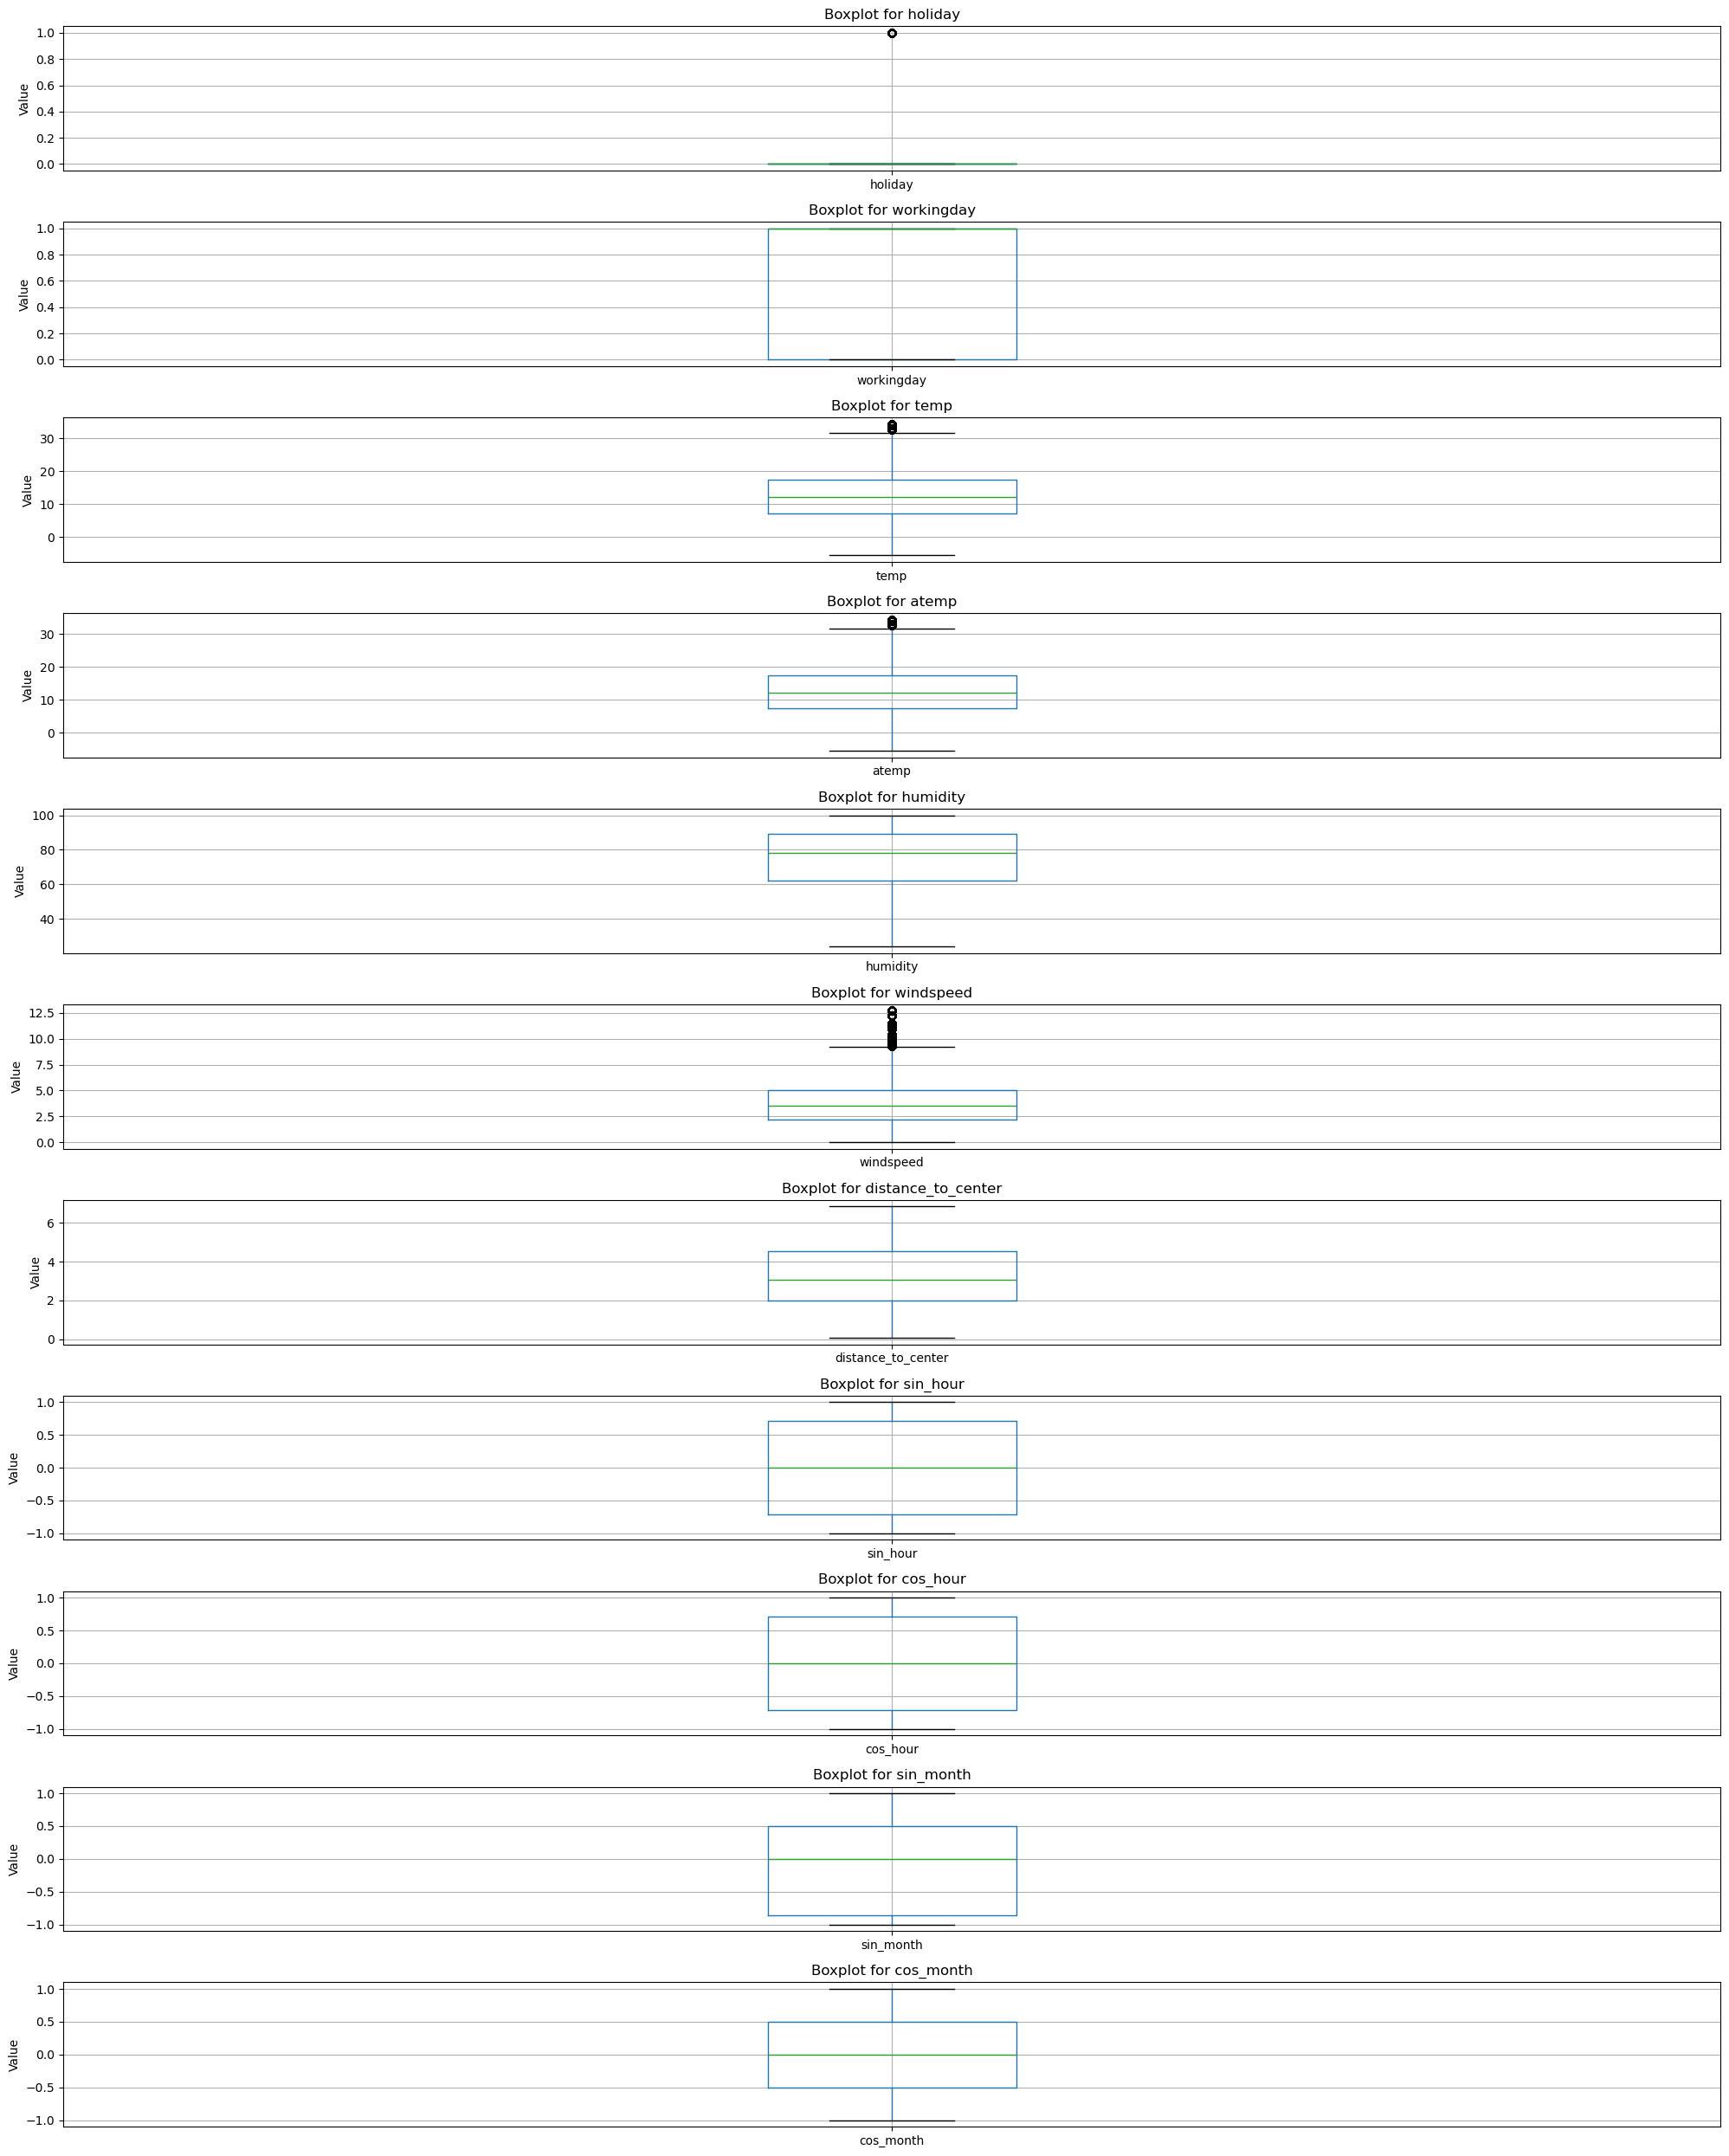

In [60]:
plt.figure(figsize=(20, 25))
plt.subplots_adjust(hspace=0.4, wspace=0.3)

# Boxplots for Numerical Columns (Outlier Detection)
numerical_cols = [col for col in required_columns if final_train_data[col].dtype in ['int64', 'float64']]

for i, col in enumerate(numerical_cols, 1):
    plt.subplot(len(numerical_cols), 1, i)  
    final_train_data.boxplot(column=col)
    plt.title(f'Boxplot for {col}')
    plt.ylabel('Value')

plt.tight_layout()
plt.show()


We can see that there are outliers in columns like holiday, windspeed and temperature. We will handle them later

In [88]:
# Outlier Analysis using IQR Method
print("Outlier Analysis:")
for col in numerical_cols:
    Q1 = final_train_data[col].quantile(0.25)
    Q3 = final_train_data[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = final_train_data[(final_train_data[col] < lower_bound) | (final_train_data[col] > upper_bound)]
    print(f"{col} Outliers: {len(outliers)} ({len(outliers)/len(final_train_data)*100:.2f}%)")
    print(f"  Lower bound: {lower_bound}, Upper bound: {upper_bound}\n")

Outlier Analysis:
holiday Outliers: 14688 (2.96%)
  Lower bound: 0.0, Upper bound: 0.0

workingday Outliers: 0 (0.00%)
  Lower bound: -1.5, Upper bound: 2.5

temp Outliers: 654 (0.13%)
  Lower bound: -7.850000000000023, Upper bound: 32.55000000000007

atemp Outliers: 654 (0.13%)
  Lower bound: -7.850000000000023, Upper bound: 32.55000000000007

humidity Outliers: 0 (0.00%)
  Lower bound: 21.5, Upper bound: 129.5

windspeed Outliers: 4164 (0.84%)
  Lower bound: -1.9999999999999991, Upper bound: 9.2

distance_to_center Outliers: 0 (0.00%)
  Lower bound: -1.8785085670519126, Upper bound: 8.408684499661916

sin_hour Outliers: 0 (0.00%)
  Lower bound: -2.8284271247461907, Upper bound: 2.8284271247461903

cos_hour Outliers: 0 (0.00%)
  Lower bound: -2.8284271247461907, Upper bound: 2.8284271247461903

sin_month Outliers: 0 (0.00%)
  Lower bound: -2.9150635094610964, Upper bound: 2.5490381056766584

cos_month Outliers: 0 (0.00%)
  Lower bound: -2.000000000000001, Upper bound: 2.00000000000000

Now, these numbers give a sense of more numerical understanding of outliers.
Note: Holiday has only few values other than 0, hence those values are treated as outliers. 
We should handle that while dealing with outliers

Text(0.5, 1.0, 'Distribution of log_bike_count')

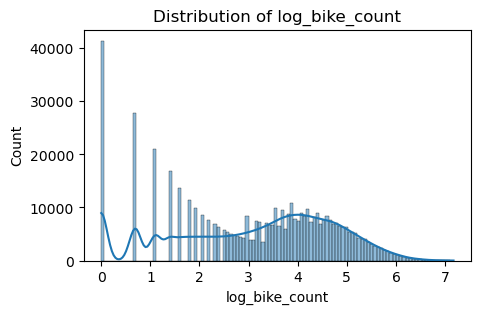

In [70]:
# Distribution of Target Variable
plt.figure(figsize=(5, 3))
sns.histplot(final_train_data['log_bike_count'], kde=True)
plt.title('Distribution of log_bike_count')

/var/folders/tc/ddy9q3l50gv9sy77lbp_p_cr0000gn/T/ipykernel_22487/4231930340.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_train_data['target_bins'] = pd.qcut(final_train_data['log_bike_count'], q=4)


<Axes: xlabel='target_bins', ylabel='count'>

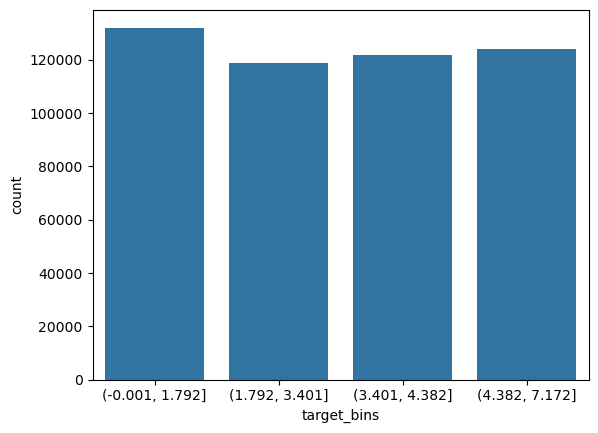

In [100]:
final_train_data['target_bins'] = pd.qcut(final_train_data['log_bike_count'], q=4)
sns.countplot(x='target_bins', data=final_train_data)


The above 2 plots analysed our target variable. The distribution as we can see is not properly even across all bins

Text(0.5, 1.0, 'Correlation Heatmap')

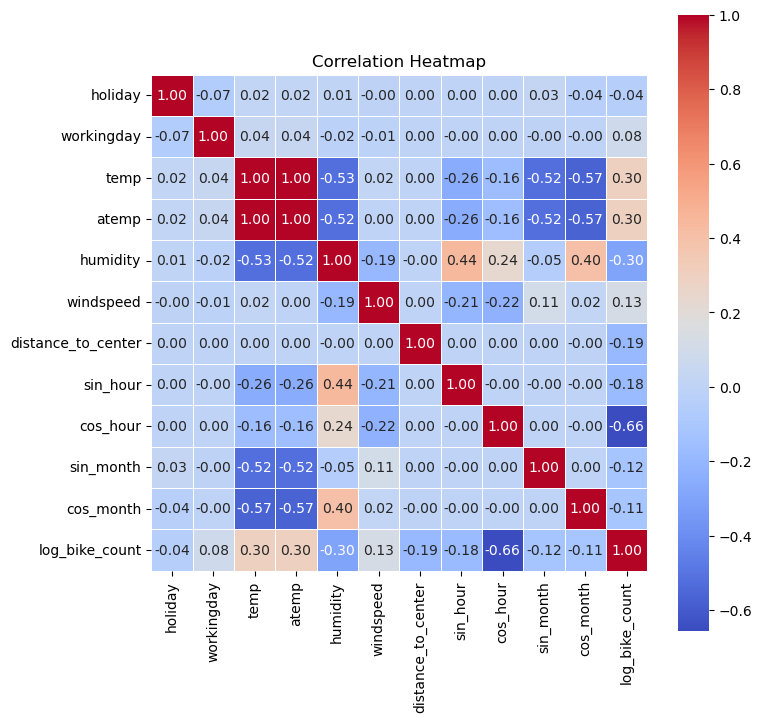

In [76]:
# Correlation Heatmap
plt.figure(figsize=(8, 8))
correlation_matrix = final_train_data[numerical_cols + ['log_bike_count']].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5, fmt='.2f', square=True)
plt.title('Correlation Heatmap')

We look for Correlations. 
1. We see that cos_hour has high negetive Correlation with target. This seems like a useful information
2. atemp and temp are very correlated. It is expected as both are temperature and one is derived from another.
   For non windy days they would be equal.
3. Several other weather factors are correlated to temperature

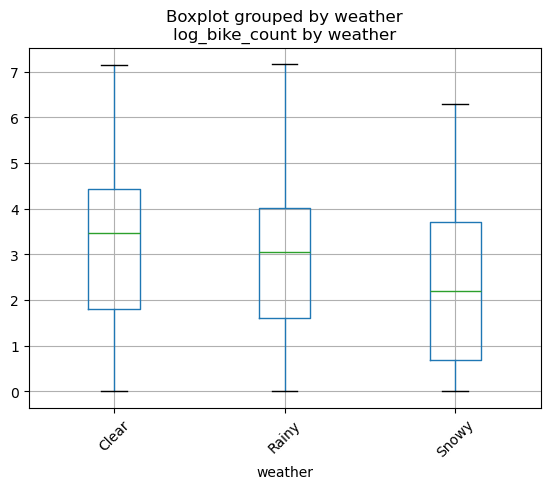

In [80]:
# Categorical Feature Impact on Target Variable
categorical_cols = [col for col in required_columns if final_train_data[col].dtype == 'object']
for i, cat_col in enumerate(categorical_cols, 1):
    final_train_data.boxplot(column='log_bike_count', by=cat_col)
    plt.title(f'log_bike_count by {cat_col}')
    plt.xticks(rotation=45)

We are analysing weather and its impact on target.
We had derived rainy, snowy and clear from the weather data
Weather has impact on target variable and different conditions have different impacts

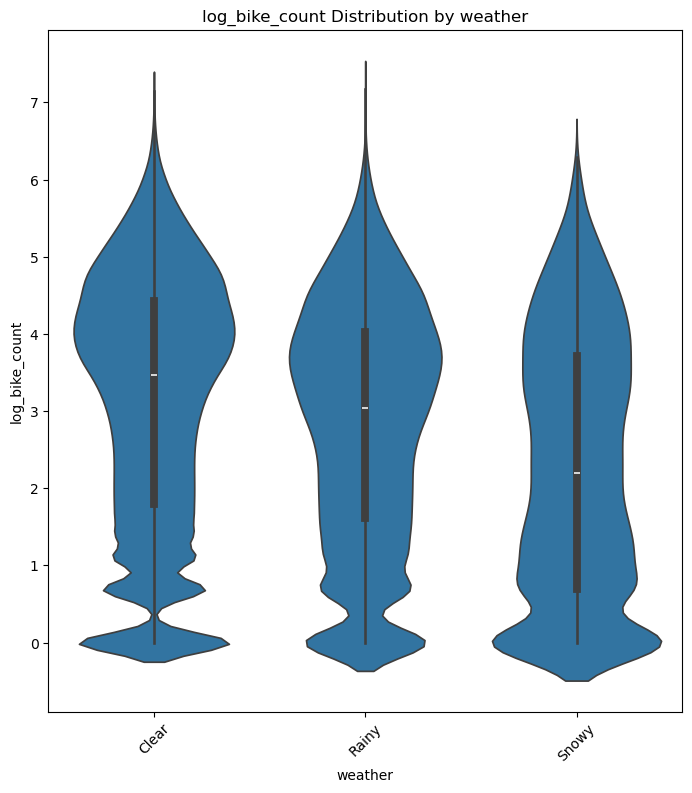

In [87]:
# 8. Violin Plots for Weather
plt.figure(figsize=(20, 15))
for i, cat_col in enumerate(categorical_cols, 1):
    plt.subplot(2, 3, i)
    sns.violinplot(x=cat_col, y='log_bike_count', data=final_train_data)
    plt.title(f'log_bike_count Distribution by {cat_col}')
    plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

We further continue to analyse it with violin plots for a more visually impactful image

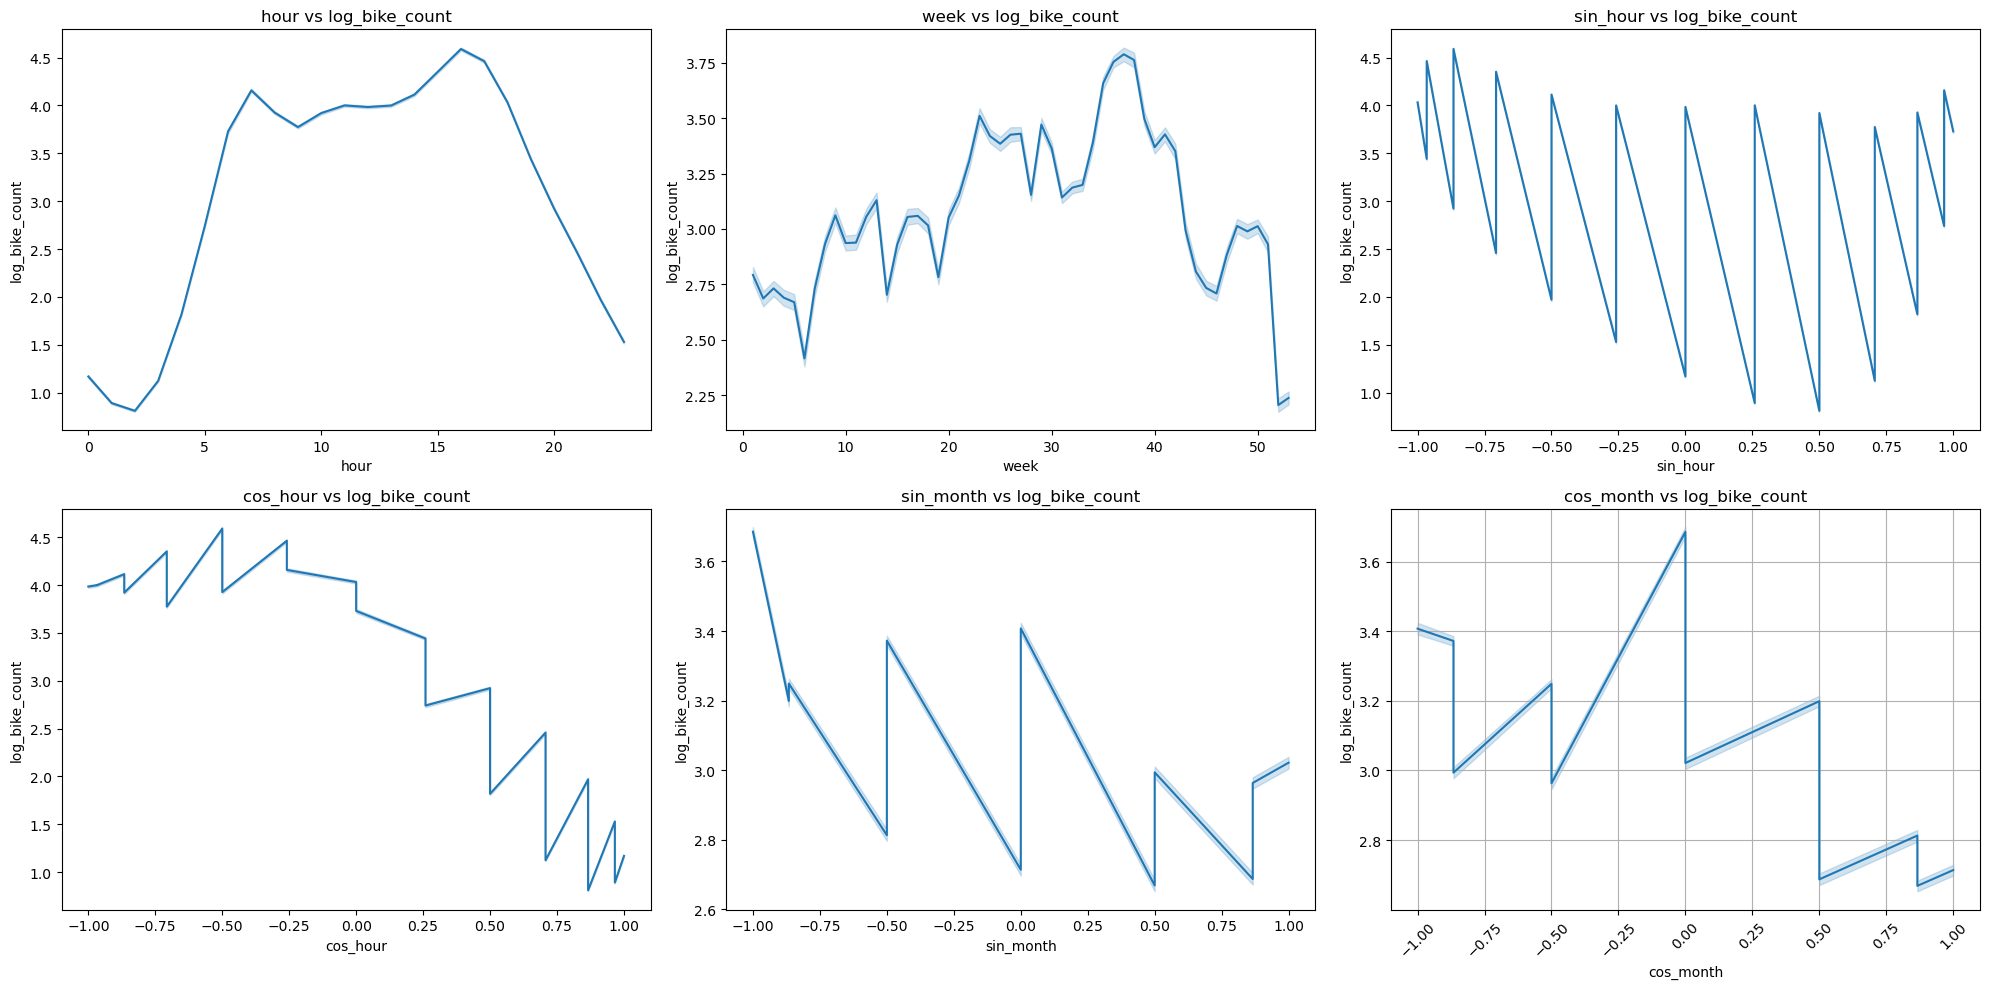

In [93]:
# Analysis by Time-Based Features
time_cols = ['hour', 'week', 'sin_hour', 'cos_hour', 'sin_month', 'cos_month']
plt.figure(figsize=(20, 10))
for i, col in enumerate(time_cols, 1):
    plt.subplot(2, 3, i)
    sns.lineplot(x=final_train_data[col], y=final_train_data['log_bike_count'])
    plt.title(f'{col} vs log_bike_count')
plt.xlabel(col)
plt.ylabel('log_bike_count')
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

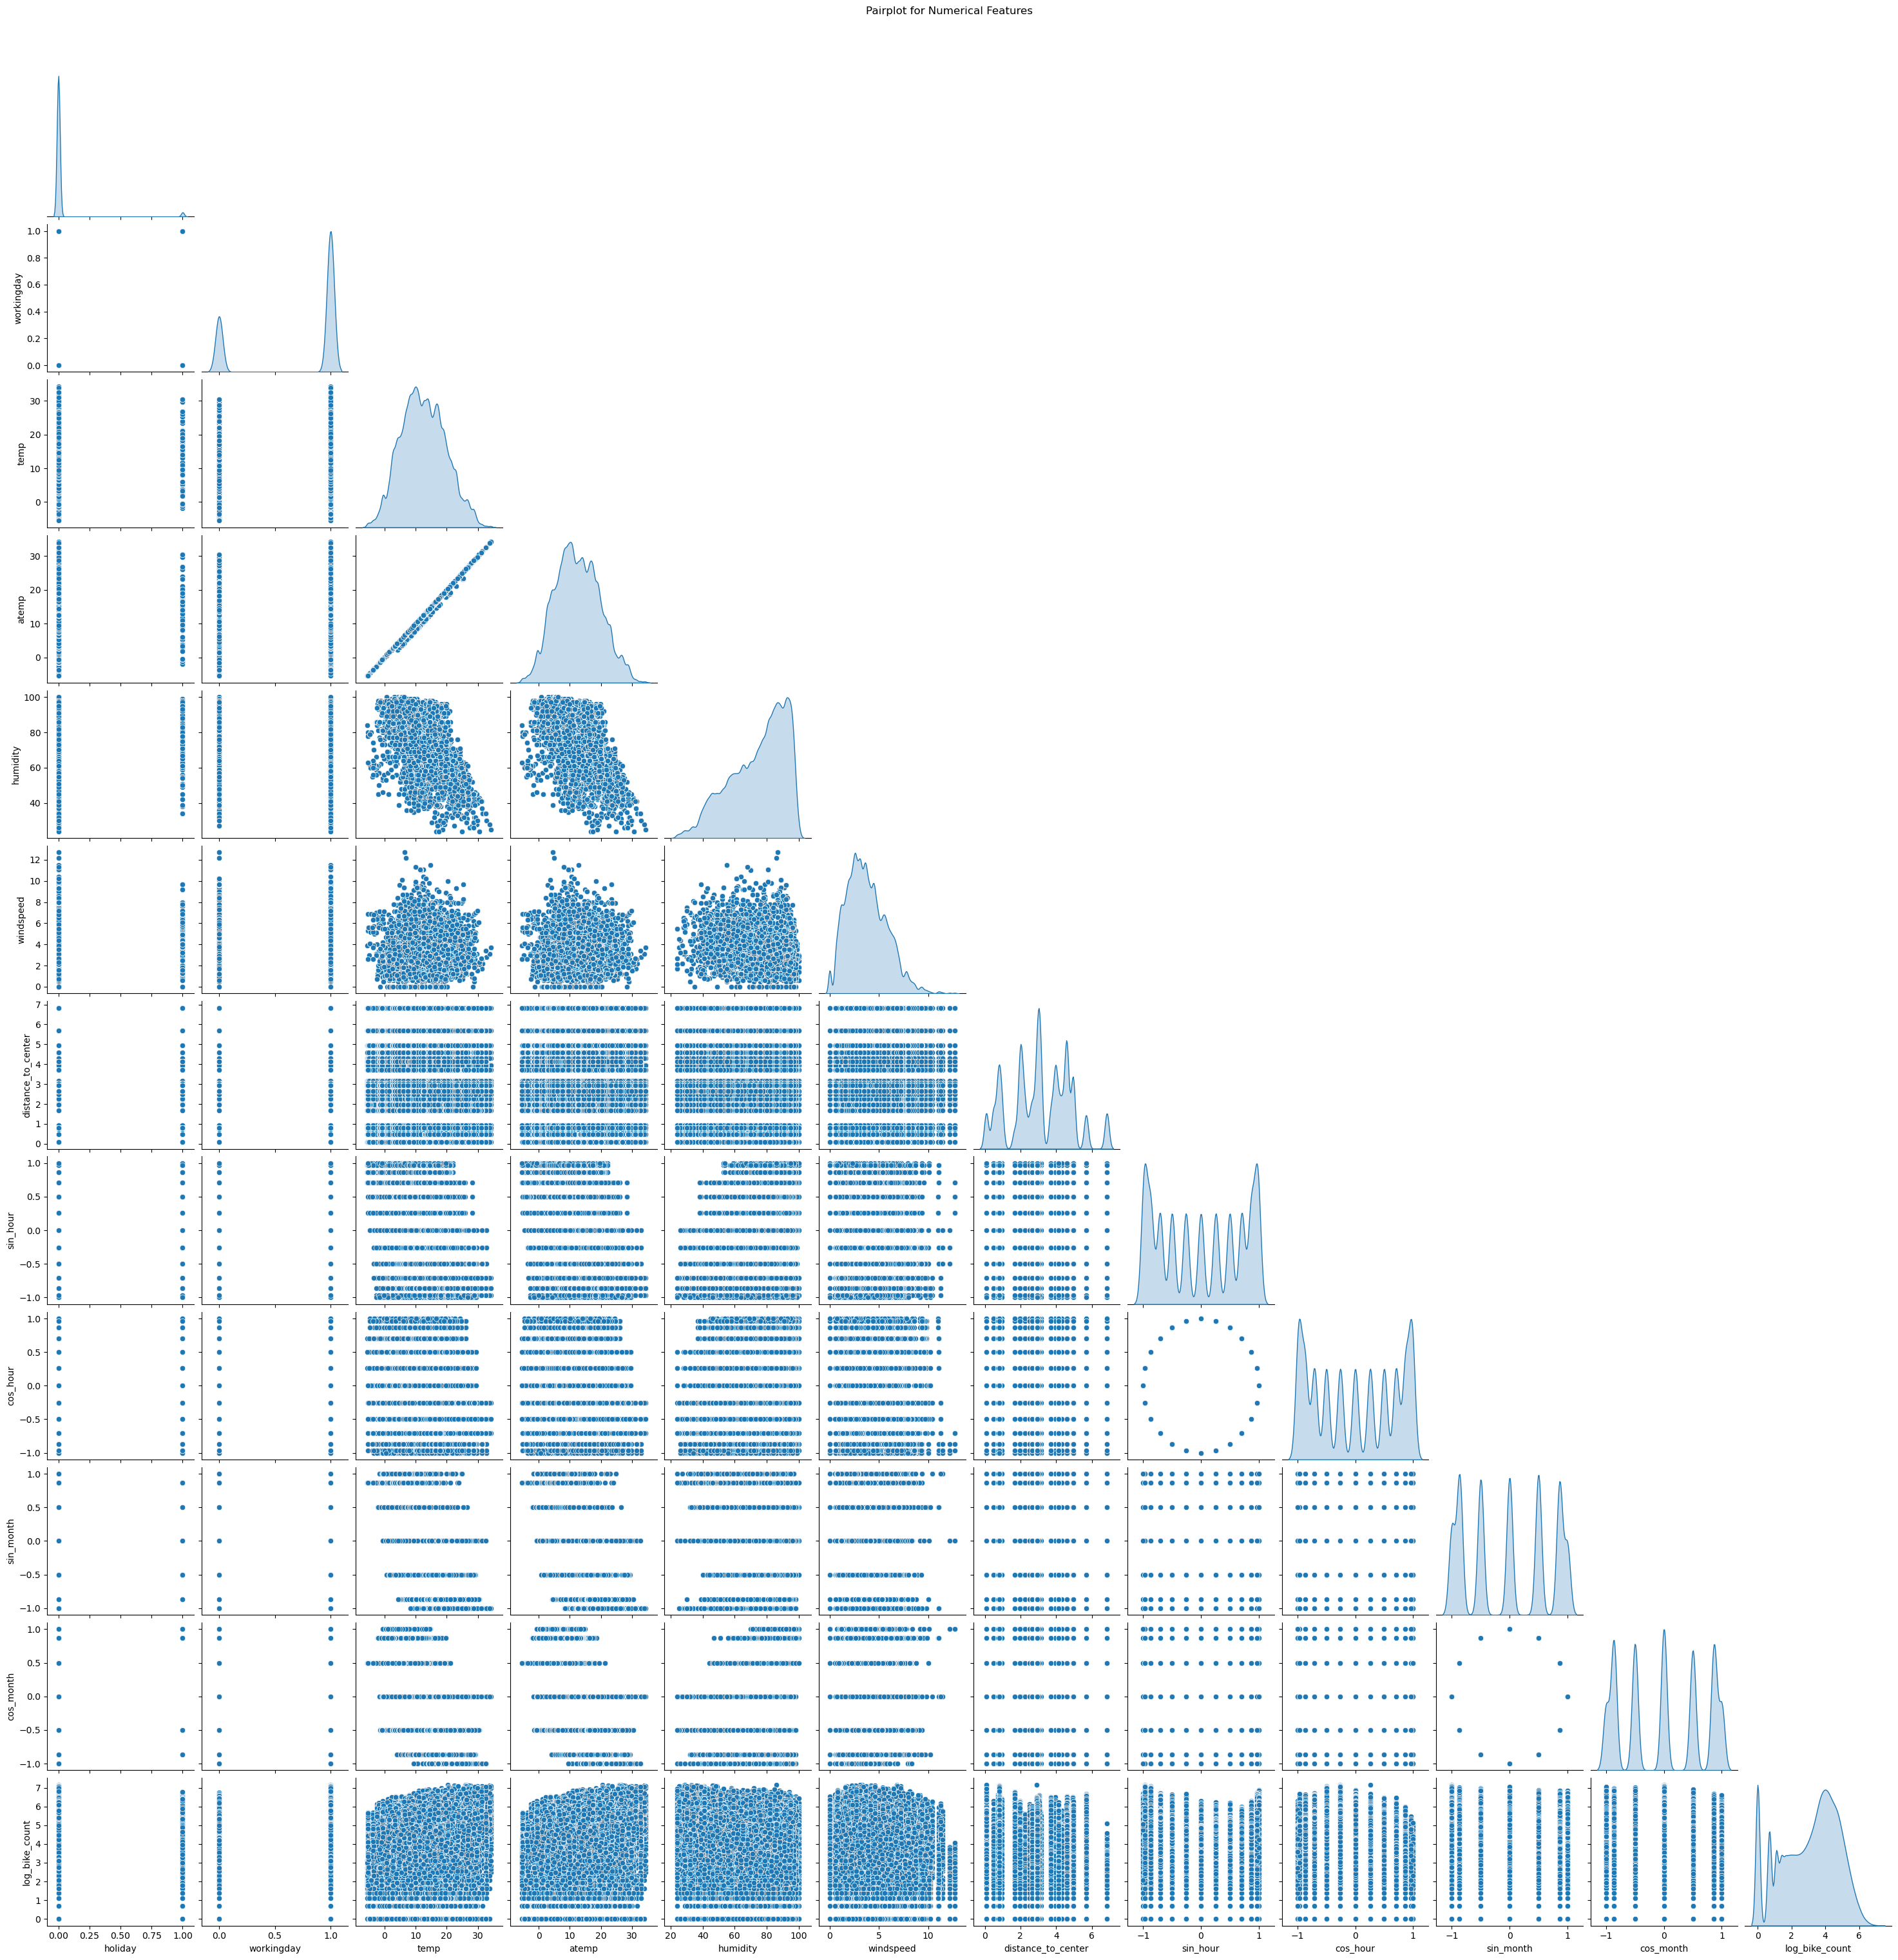

In [92]:
# Pairwise Relationships (Pairplot)
sns.pairplot(final_train_data[numerical_cols + ['log_bike_count']], diag_kind='kde', corner=True)
plt.suptitle("Pairplot for Numerical Features", y=1.02)
plt.show()

In [94]:
print("\nSkewness and Kurtosis:")
for col in numerical_cols:
    skewness = final_train_data[col].skew()
    kurtosis = final_train_data[col].kurt()
    print(f"{col}: Skewness={skewness:.2f}, Kurtosis={kurtosis:.2f}")


Skewness and Kurtosis:
holiday: Skewness=5.55, Kurtosis=28.86
workingday: Skewness=-0.96, Kurtosis=-1.08
temp: Skewness=0.16, Kurtosis=-0.42
atemp: Skewness=0.17, Kurtosis=-0.43
humidity: Skewness=-0.64, Kurtosis=-0.52
windspeed: Skewness=0.59, Kurtosis=0.18
distance_to_center: Skewness=0.05, Kurtosis=-0.56
sin_hour: Skewness=0.00, Kurtosis=-1.50
cos_hour: Skewness=0.00, Kurtosis=-1.50
sin_month: Skewness=0.03, Kurtosis=-1.50
cos_month: Skewness=0.02, Kurtosis=-1.47


1. Features like holiday and workingday are categorical, so their skewness and kurtosis reflect their limited values or imbalanced frequency distribution.
2. Continuous features like temp, atemp, and distance_to_center show well-behaved distributions with minimal skewness or kurtosis.
3. Outliers are most pronounced in holiday, but we had explained why this is so when we saw box plots.

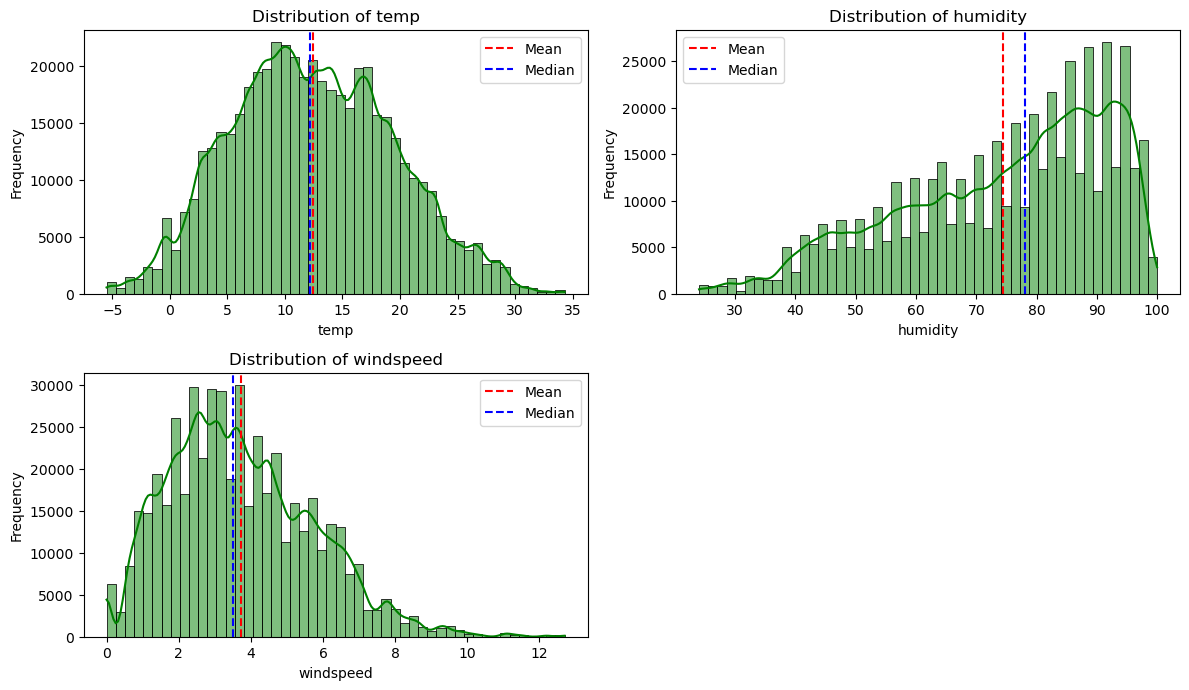

In [116]:


# Univariate Analysis: Distribution of some numerical features
features_to_plot = ['temp','humidity','windspeed']

plt.figure(figsize=(12, 10))
for i, feature in enumerate(features_to_plot, 1):
    try:
        plt.subplot(3, 2, i)
        sns.histplot(final_train_data[feature], bins=50, kde=True, color='green')
        plt.axvline(final_train_data[feature].mean(), color='red', linestyle='--', label='Mean')
        plt.axvline(final_train_data[feature].median(), color='blue', linestyle='--', label='Median')
        plt.title(f'Distribution of {feature}')
        plt.xlabel(feature)
        plt.ylabel('Frequency')
        plt.legend()
    except:
        continue
plt.tight_layout()
plt.show()




# # Bivariate Analysis with categorical variables

# boxplot_features = ['day_period', 'season', 'location_type', 'is_weekend', 'holiday', 'workingday', 'is_hot', 'is_cold', 'is_rainy', 'is_windy', 'bad_weather']

# plt.figure(figsize=(18,15))
# for i, feature in enumerate(boxplot_features, 1):
#     plt.subplot(3, 4, i)  # Adjust the grid to have 4 columns for better layout
#     sns.boxplot(x=data[feature], y=data['log_bike_count'], palette='plasma')
#     plt.title(f'Relationship between log_bike_count and {feature}')
#     plt.xlabel(feature)
#     plt.ylabel('log_bike_count')
# plt.tight_layout()
# plt.show()


We see that Humidity is right skewed.

In [18]:
# We check if there are any column with >40% missing vals and dropping cols with >40% missing vals

missing_percentage = final_train_data.isna().mean() * 100

cols_to_drop = missing_percentage[missing_percentage > 40].index

train_data_cleaned = final_train_data.drop(columns=cols_to_drop)

print(f"Columns dropped: {cols_to_drop}")
print(f"Updated DataFrame shape: {train_data_cleaned.shape}")

print("Missing values after dropping columns with > 40% NaN values:")
print(train_data_cleaned.isna().sum())

Columns dropped: Index([], dtype='object')
Updated DataFrame shape: (496827, 16)
Missing values after dropping columns with > 40% NaN values:
season                0
holiday               0
workingday            0
weather               0
school_holiday        0
year                  0
hour                  0
week                  0
distance_to_center    0
sin_hour              0
cos_hour              0
sin_month             0
cos_month             0
day_period            0
log_bike_count        0
bike_count            0
dtype: int64


There are no such columns with > 40% NaN values

In [20]:
# Handle the null values
# Numeric columns: Linear Interpolation
# Categoric columns: Mode

def handle_missing_and_infs(df):
    for column in df.columns:
        if df[column].dtype in ['float64', 'int64']:  
            df[column].replace([np.inf, -np.inf], np.nan, inplace=True)
            df[column].interpolate(method='linear', inplace=True)
        else:  
            if df[column].isna().sum() > 0:  
                if df[column].dtype == 'object':
                    df[column].fillna(df[column].mode()[0], inplace=True)  
                elif pd.api.types.is_categorical_dtype(df[column]):
                    df[column].fillna(df[column].mode()[0], inplace=True)  
    return df

train_data_cleaned = handle_missing_and_infs(train_data_cleaned)
print("Missing values after handling:")
print(train_data_cleaned.isna().sum())
missing_values_train = pd.DataFrame(train_data_cleaned.isna().sum(), columns=["missing_count"])
columns_with_missing_values = missing_values_train[missing_values_train["missing_count"] > 0]
for col in columns_with_missing_values.index:
    if train_data_cleaned[col].dtype in ['float64', 'int64']:
        train_data_cleaned[col].fillna(train_data_cleaned[col].mean(), inplace=True)
print("Missing values after handling:")
print(train_data_cleaned.isna().sum())
missing_values_train = pd.DataFrame(train_data_cleaned.isna().sum(), columns=["missing_count"])
columns_with_missing_values = missing_values_train[missing_values_train["missing_count"] > 0]
num_columns_with_missing_values = columns_with_missing_values.shape[0]
print(f"Number of columns with missing values: {num_columns_with_missing_values}")
print(columns_with_missing_values)

Missing values after handling:
season                0
holiday               0
workingday            0
weather               0
school_holiday        0
year                  0
hour                  0
week                  0
distance_to_center    0
sin_hour              0
cos_hour              0
sin_month             0
cos_month             0
day_period            0
log_bike_count        0
bike_count            0
dtype: int64
Missing values after handling:
season                0
holiday               0
workingday            0
weather               0
school_holiday        0
year                  0
hour                  0
week                  0
distance_to_center    0
sin_hour              0
cos_hour              0
sin_month             0
cos_month             0
day_period            0
log_bike_count        0
bike_count            0
dtype: int64
Number of columns with missing values: 0
Empty DataFrame
Columns: [missing_count]
Index: []


/var/folders/tc/ddy9q3l50gv9sy77lbp_p_cr0000gn/T/ipykernel_22487/1872952295.py:4: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[column].replace([np.inf, -np.inf], np.nan, inplace=True)
/var/folders/tc/ddy9q3l50gv9sy77lbp_p_cr0000gn/T/ipykernel_22487/1872952295.py:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting 

In [123]:
train_data_cleaned.columns

Index(['site_id', 'site_name', 'bike_count', 'date',
       'counter_installation_date', 'coordinates', 'counter_technical_id',
       'latitude', 'longitude', 'log_bike_count', 'year', 'month', 'day',
       'weekday', 'hour', 'holiday', 'week_of_month', 'workingday', 'season',
       'numer_sta', 'pmer', 'tend', 'cod_tend', 'dd', 'windspeed', 't', 'td',
       'humidity', 'vv', 'ww', 'w1', 'w2', 'n', 'nbas', 'hbas', 'cl', 'pres',
       'tend24', 'raf10', 'rafper', 'per', 'etat_sol', 'ht_neige', 'ssfrai',
       'perssfrai', 'rr1', 'rr3', 'rr6', 'rr12', 'rr24', 'nnuage1', 'ctype1',
       'hnuage1', 'is_weekend', 'installation_age_days', 'distance_to_center',
       'location_type', 'is_rainy', 'is_windy', 'low_visibility', 'temp',
       'is_hot', 'is_cold', 'is_snowy', 'bad_weather', 'day_period', 'week',
       'weather', 'sin_hour', 'cos_hour'],
      dtype='object')

In [22]:

# Encoding categoric columns using label encoder



label_encoders = {}
categorical_cols = train_data_cleaned.select_dtypes(include=['object', 'category']).columns
for col in categorical_cols:
    unique_count = train_data_cleaned[col].nunique()

    if unique_count > 50:
        print(f"Dropping column '{col}' with {unique_count} unique categories.")
        train_data_cleaned.drop(columns=[col], inplace=True)
    else:
        print(f"Encoding column '{col}' with {unique_count} unique categories.")
        le = LabelEncoder()
        train_data_cleaned[col] = le.fit_transform(train_data_cleaned[col].astype(str))
        label_encoders[col] = le

with open('label_encoders.pkl', 'wb') as f:
    pickle.dump(label_encoders, f)
print("Updated dataset:")
print(train_data_cleaned.head())

Encoding column 'weather' with 3 unique categories.
Encoding column 'day_period' with 4 unique categories.
Updated dataset:
     season  holiday  workingday  weather  school_holiday  year  hour  week  \
107       3        0           1        0           False  2020     2    36   
153       3        0           1        0           False  2020     3    36   
201       3        0           1        0           False  2020     4    36   
782       3        0           1        0           False  2020    15    36   
925       3        0           1        0           False  2020    18    36   

     distance_to_center  sin_hour      cos_hour  sin_month     cos_month  \
107            2.070853  0.500000  8.660254e-01       -1.0 -1.836970e-16   
153            2.070853  0.707107  7.071068e-01       -1.0 -1.836970e-16   
201            2.070853  0.866025  5.000000e-01       -1.0 -1.836970e-16   
782            2.070853 -0.707107 -7.071068e-01       -1.0 -1.836970e-16   
925            2.0708

In [24]:
def cap_outliers(df, threshold=5, exclude_columns=None):
    if exclude_columns is None:
        exclude_columns = []

    for col in df.select_dtypes(include=[np.number]).columns:
        if col in exclude_columns:
            continue

        mean = df[col].mean()
        std_dev = df[col].std()

        lower_limit = mean - threshold * std_dev
        upper_limit = mean + threshold * std_dev

        df[col] = np.clip(df[col], lower_limit, upper_limit)

    return df

# Avoid applying to the "holiday" column
# Clipping values crossing upper and lower limit (mean +/- 4 * std_dev)
train_data_cleaned = cap_outliers(train_data_cleaned, threshold=4, exclude_columns=['holiday'])
print(train_data_cleaned)


        season  holiday  workingday  weather  school_holiday  year  hour  \
107          3      0.0           1      0.0           False  2020     2   
153          3      0.0           1      0.0           False  2020     3   
201          3      0.0           1      0.0           False  2020     4   
782          3      0.0           1      0.0           False  2020    15   
925          3      0.0           1      0.0           False  2020    18   
...        ...      ...         ...      ...             ...   ...   ...   
495819       3      0.0           1      0.0           False  2021     6   
496091       3      0.0           1      0.0           False  2021    10   
496354       3      0.0           1      0.0           False  2021    15   
496719       3      0.0           1      0.0           False  2021    22   
496826       3      0.0           1      0.0           False  2021    23   

        week  distance_to_center  sin_hour      cos_hour  sin_month  \
107       36    

In [26]:
cols_to_drop = ['log_bike_count', 'bike_count']
X = train_data_cleaned.drop(columns=cols_to_drop)
y = train_data_cleaned['log_bike_count']
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size = 0.3, random_state = 17)

In [192]:
# trying out diff models and seeing which one works the best for our dataset

models = [LinearRegression(), Lasso(), Ridge(), DecisionTreeRegressor(), RandomForestRegressor(), AdaBoostRegressor(), GradientBoostingRegressor(), KNeighborsRegressor(), XGBRegressor(),LGBMRegressor()]
model_names = ['LinearRegression', 'Lasso', 'Ridge', 'DecisionTreeRegressor', 'RandomForestRegressor', 'AdaBoostRegressor', 'GradientBoostingRegressor', 'KNeighborsRegressor', 'XGBRegressor','LightGBM']
r2_train = []
r2_val = []
i = 0
for model in models:
    print(i)
    i=i+1
    mod = model
    mod.fit(X_train, y_train)
    y_pred_train = mod.predict(X_train)
    y_pred_train = y_pred_train.clip(0)
    y_pred_val = mod.predict(X_val)
    y_pred_val = y_pred_val.clip(0)
    r2_train.append(r2_score(y_train, y_pred_train))
    r2_val.append(r2_score(y_val, y_pred_val))
data = {'Modelling Algorithm' : model_names, 'Train R2' : r2_train, 'Validation R2' : r2_val}
data = pd.DataFrame(data)
data['Difference'] = ((np.abs(data['Train R2'] - data['Validation R2'])) * 100)/(data['Train R2'])
data.sort_values(by = 'Validation R2', ascending = False)

0
1
2
3
4
5
6
7
8
9


,Modelling Algorithm,Train R2,Validation R2,Difference
8,XGBRegressor,0.896524,0.892782,0.417407
9,LightGBM,0.877240,0.875182,0.234666
4,RandomForestRegressor,0.950266,0.839754,11.629540
6,GradientBoostingRegressor,0.786181,0.784371,0.230232
3,DecisionTreeRegressor,0.956153,0.762740,20.228254
7,KNeighborsRegressor,0.809506,0.702326,13.240206
5,AdaBoostRegressor,0.585529,0.585824,0.050414
0,LinearRegression,0.556188,0.553858,0.418993
2,Ridge,0.556188,0.553858,0.418992
1,Lasso,0.135104,0.134083,0.755474


XGBRegressor and LightGBM works the best for our dataset

In [28]:
# Finding optimal paramaters for LGBMRegressor with RandomizedSearchCV



param_dist = {
    'num_leaves': np.arange(20, 300, step=5),
    'learning_rate': np.logspace(-3, 0, num=100),
    'n_estimators': np.arange(100, 1000, step=50),
    'max_bin': np.arange(50, 255, step=5),
    'min_child_samples': np.arange(5, 50, step=5),
    'reg_alpha': np.logspace(-4, 0, num=50),
    'reg_lambda': np.logspace(-4, 0, num=50),
    'colsample_bytree': np.linspace(0.4, 1.0, num=50)
}

lgbm = LGBMRegressor(n_jobs=-1, verbose=-1)

random_search = RandomizedSearchCV(
    estimator=lgbm,
    param_distributions=param_dist,
    n_iter=100,  
    scoring='neg_mean_squared_error',
    cv=5,  
    random_state=42,
    verbose=1
)

random_search.fit(X_train, y_train)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


RandomizedSearchCV(cv=5, estimator=LGBMRegressor(n_jobs=-1, verbose=-1),
                   n_iter=100,
                   param_distributions={'colsample_bytree': array([0.4       , 0.4122449 , 0.4244898 , 0.43673469, 0.44897959,
       0.46122449, 0.47346939, 0.48571429, 0.49795918, 0.51020408,
       0.52244898, 0.53469388, 0.54693878, 0.55918367, 0.57142857,
       0.58367347, 0.59591837, 0.60816327, 0.62040816, 0.63265306,
       0.64489796,...
       1.93069773e-02, 2.32995181e-02, 2.81176870e-02, 3.39322177e-02,
       4.09491506e-02, 4.94171336e-02, 5.96362332e-02, 7.19685673e-02,
       8.68511374e-02, 1.04811313e-01, 1.26485522e-01, 1.52641797e-01,
       1.84206997e-01, 2.22299648e-01, 2.68269580e-01, 3.23745754e-01,
       3.90693994e-01, 4.71486636e-01, 5.68986603e-01, 6.86648845e-01,
       8.28642773e-01, 1.00000000e+00])},
                   random_state=42, scoring='neg_mean_squared_error',
                   verbose=1)

In [29]:
# Evaluate the best model on the test set
best_model = random_search.best_estimator_
y_pred = best_model.predict(X_val)
mse = mean_squared_error(y_val, y_pred)
rmse = np.sqrt(mse)
print("Best Parameters:", random_search.best_params_)
print("Test RMSE:", rmse)

Best Parameters: {'reg_lambda': 0.8286427728546842, 'reg_alpha': 0.010985411419875584, 'num_leaves': 215, 'n_estimators': 500, 'min_child_samples': 35, 'max_bin': 55, 'learning_rate': 0.06135907273413173, 'colsample_bytree': 0.5836734693877551}
Test RMSE: 0.5305627238766532


In [30]:
best_model

LGBMRegressor(colsample_bytree=0.5836734693877551,
              learning_rate=0.06135907273413173, max_bin=55,
              min_child_samples=35, n_estimators=500, n_jobs=-1, num_leaves=215,
              reg_alpha=0.010985411419875584, reg_lambda=0.8286427728546842,
              verbose=-1)

In [31]:
# Get feature importances if available
if hasattr(best_model, "feature_importances_"):
    feature_importances = best_model.feature_importances_
    features = X_val.columns if hasattr(X_val, "columns") else np.arange(len(feature_importances))
    feature_importance_df = pd.DataFrame({
        "Feature": features,
        "Importance": feature_importances
    }).sort_values(by="Importance", ascending=False)

    print("\nFeature Importances:")
    print(feature_importance_df)
else:
    print("\nThe best model does not support feature importances.")



Feature Importances:
               Feature  Importance
6                 hour       22906
7                 week       20092
8   distance_to_center       12474
9             sin_hour       11226
10            cos_hour        8614
11           sin_month        6955
12           cos_month        4973
0               season        4462
3              weather        3553
13          day_period        3019
4       school_holiday        3012
2           workingday        2967
1              holiday        1613
5                 year        1043


In [224]:
# Finding optimal paramaters for XGBRegressor with RandomizedSearchCV

param_dist_xgb = {
    'n_estimators': np.arange(100, 301, step=50),  
    'learning_rate': np.linspace(0.01, 0.3, num=10),  
    'max_depth': np.arange(5, 13, step=2),  
    'min_child_weight': np.arange(1, 6, step=2),  
    'gamma': np.linspace(0.1, 0.5, num=5),  
    'subsample': np.linspace(0.7, 1.0, num=4),  
    'colsample_bytree': np.linspace(0.7, 1.0, num=4),  
    'reg_alpha': np.linspace(0.1, 0.5, num=5),  
    'reg_lambda': np.linspace(0.1, 0.5, num=5)  
}

xgb = XGBRegressor(
    n_jobs=-1,
    verbosity=0,  
    objective='reg:squarederror',  
    random_state=42
)

random_search_xgb = RandomizedSearchCV(
    estimator=xgb,
    param_distributions=param_dist_xgb,
    n_iter=100,
    scoring='neg_mean_squared_error',
    cv=3,
    random_state=42,
    verbose=1
)

random_search_xgb.fit(X_train, y_train)


Fitting 3 folds for each of 100 candidates, totalling 300 fits


RandomizedSearchCV(cv=3,
                   estimator=XGBRegressor(base_score=None, booster=None,
                                          callbacks=None,
                                          colsample_bylevel=None,
                                          colsample_bynode=None,
                                          colsample_bytree=None, device=None,
                                          early_stopping_rounds=None,
                                          enable_categorical=False,
                                          eval_metric=None, feature_types=None,
                                          gamma=None, grow_policy=None,
                                          importance_type=None,
                                          interaction_constraints=None,
                                          learning_rate=...
                                        'learning_rate': array([0.01      , 0.04222222, 0.07444444, 0.10666667, 0.13888889,
       0.17111111, 0.20333333, 0.23555556, 0.26777778, 0.3       ]),
                                        'max_depth': array([ 5,  7,  9, 11]),
                                        'min_child_weight': array([1, 3, 5]),
                                        'n_estimators': array([100, 150, 200, 250, 300]),
                                        'reg_alpha': array([0.1, 0.2, 0.3, 0.4, 0.5]),
                                        'reg_lambda': array([0.1, 0.2, 0.3, 0.4, 0.5]),
                                        'subsample': array([0.7, 0.8, 0.9, 1. ])},
                   random_state=42, scoring='neg_mean_squared_error',
                   verbose=1)

In [225]:
# Evaluate the best model on the test set
best_model_xgb = random_search_xgb.best_estimator_
y_pred = best_model_xgb.predict(X_val)
mse = mean_squared_error(y_val, y_pred)
rmse = np.sqrt(mse)
print("Best Parameters:", random_search.best_params_)
print("Test RMSE:", rmse)

Best Parameters: {'reg_lambda': 0.005179474679231213, 'reg_alpha': 0.010985411419875584, 'num_leaves': 200, 'n_estimators': 900, 'min_child_samples': 45, 'max_bin': 90, 'learning_rate': 0.03274549162877728, 'colsample_bytree': 0.6816326530612244}
Test RMSE: 0.5188333872427325


In [253]:

# Combining the above two models with StackingRegressor

from sklearn.ensemble import StackingRegressor

estimators = [
    ('xgb', best_model_xgb),
    ('lgbm', best_model)
]

stacking_regressor = StackingRegressor(
    estimators=estimators,
    final_estimator=GradientBoostingRegressor(),
    cv=5
)



In [255]:
stacking_regressor.fit(X_train, y_train)


StackingRegressor(cv=5,
                  estimators=[('xgb',
                               XGBRegressor(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=0.7, device=None,
                                            early_stopping_rounds=None,
                                            enable_categorical=False,
                                            eval_metric=None,
                                            feature_types=None, gamma=0.4,
                                            grow_policy=None,
                                            importance_type=None,
                                            interaction_constraints=None,
                                            learning...
                                            n_estimators=200, n_jobs=-1,
                                            num_parallel_tree=None,
                                            random_state=42, ...)),
                              ('lgbm',
                               LGBMRegressor(colsample_bytree=0.6816326530612244,
                                             learning_rate=0.03274549162877728,
                                             max_bin=90, min_child_samples=45,
                                             n_estimators=900, n_jobs=-1,
                                             num_leaves=200,
                                             reg_alpha=0.010985411419875584,
                                             reg_lambda=0.005179474679231213,
                                             verbose=-1))],
                  final_estimator=GradientBoostingRegressor())

In [261]:
# Evaluate the best model on the test set
y_pred = stacking_regressor.predict(X_val)
mse = mean_squared_error(y_val, y_pred)
rmse = np.sqrt(mse)
print("Test RMSE:", rmse)

Test RMSE: 0.5121274783931553


Preprocessing our test dataset

In [157]:

test_path = 'data/final_test.parquet'
test_data = pd.read_parquet(Path(test_path))
print(test_data.columns)

test_data = external_data.example_estimator._encode_dates(test_data)
test_data = external_data.example_estimator._merge_external_data(test_data)

test_data['is_weekend'] = test_data['weekday'].isin([5, 6]).astype(int)

test_data = test_data.drop(columns=['counter_name', 'site_name', 'week_of_month'])

city_center = (48.8566, 2.3522)
test_data['distance_to_center'] = test_data.apply(
    lambda row: distance(city_center, (row['latitude'], row['longitude'])).km,
    axis=1
)

kmeans = KMeans(n_clusters=2, random_state=42)
test_data['location_type'] = kmeans.fit_predict(test_data[['latitude', 'longitude']])

test_data['is_rainy'] = (test_data['rr1'] > 0).astype(int)
test_data['is_windy'] = (test_data['ff'] > 8).astype(int)
test_data['low_visibility'] = (test_data['vv'] < 1000).astype(int)


test_data['day_period'] = pd.cut(
    test_data['hour'],
    bins=[0, 6, 12, 18, 24],
    labels=['Night', 'Morning', 'Afternoon', 'Evening'],
    right=False
)

test_data['temperature_c'] = test_data['t'] - 273.15  # Kelvin to Celsius
test_data['is_hot'] = (test_data['temperature_c'] > 20).astype(int)
test_data['is_cold'] = (test_data['temperature_c'] < 5).astype(int)
test_data['is_snowy'] = (test_data['temperature_c'] < 0).astype(int)



test_data['sin_hour'] = np.sin(test_data['hour'] * (2 * np.pi / 24))
test_data['cos_hour'] = np.cos(test_data['hour'] * (2 * np.pi / 24))
test_data['sin_month'] = np.sin(test_data['month'] * (2 * np.pi / 12))
test_data['cos_month'] = np.cos(test_data['month'] * (2 * np.pi / 12))

test_data.rename(columns={
    'workday': 'workingday',
    'temperature_c': 'temp',
    'u': 'humidity',
    'ff': 'windspeed'
}, inplace=True)

if 'atemp' not in test_data.columns:
    test_data['atemp'] = np.where(test_data['is_windy'] == 1, test_data['temp'] - 2, test_data['temp'])

if 'week' not in test_data.columns:
    test_data['week'] = pd.to_datetime(test_data['date']).dt.isocalendar().week

if 'weather' not in test_data.columns:
    conditions = [
        (test_data['is_rainy'] == 1),
        (test_data['is_snowy'] == 1)
    ]
    choices = ['Rainy', 'Snowy']
    test_data['weather'] = np.select(conditions, choices, default='Clear')





Index(['counter_id', 'counter_name', 'site_id', 'site_name', 'date',
       'counter_installation_date', 'coordinates', 'counter_technical_id',
       'latitude', 'longitude'],
      dtype='object')


In [159]:


test_data["date"] = pd.to_datetime(test_data["date"]).dt.tz_localize(None)



test_data["school_holiday"] = is_school_holiday_vectorized(test_data["date"], holidays)

test_data.head(5)

/var/folders/tc/ddy9q3l50gv9sy77lbp_p_cr0000gn/T/ipykernel_1111/2058138871.py:10: FutureWarning: Logical ops (and, or, xor) between Pandas objects and dtype-less sequences (e.g. list, tuple) are deprecated and will raise in a future version. Wrap the object in a Series, Index, or np.array before operating instead.
  is_holiday = is_holiday | ((dates >= row["Start_Date"]) & (dates <= row["End_Date"])).astype(int)


,counter_id,site_id,date,counter_installation_date,coordinates,counter_technical_id,latitude,longitude,year,month,day,weekday,hour,holiday,workingday,season,numer_sta,pmer,tend,cod_tend,dd,windspeed,t,td,humidity,vv,ww,w1,w2,n,nbas,hbas,cl,cm,ch,pres,niv_bar,geop,tend24,tn12,tn24,tx12,tx24,tminsol,sw,tw,raf10,rafper,per,etat_sol,ht_neige,ssfrai,perssfrai,rr1,rr3,rr6,rr12,rr24,phenspe1,phenspe2,phenspe3,phenspe4,nnuage1,ctype1,hnuage1,nnuage2,ctype2,hnuage2,nnuage3,ctype3,hnuage3,nnuage4,ctype4,hnuage4,is_weekend,installation_age_days,distance_to_center,location_type,is_rainy,is_windy,low_visibility,total_precipitation_24h,day_period,temp,is_hot,is_cold,is_snowy,bad_weather,sin_hour,cos_hour,sin_month,cos_month,atemp,week,weather,school_holiday
0,100007049-102007049,100007049,2021-09-10 01:00:00,2013-01-18,"48.846028,2.375429",Y2H15027244,48.846028,2.375429,2021,9,10,4,1,0,1,3,7149,101240,0,0,200,2.0,291.45,290.45,94,34270,0,1.0,1.0,100.0,8.0,5340.0,NaN,NaN,NaN,100190,NaN,NaN,100.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.4,3.4,-10,1.0,0.0,NaN,NaN,0.0,0.0,0.0,0.6,0.6,NaN,NaN,NaN,NaN,6.0,NaN,5340.0,8.0,NaN,7020.0,NaN,NaN,NaN,NaN,NaN,NaN,0,3157,2.070853,0,0,0,0,1.2,Night,18.3,0,0,0,0,0.258819,0.965926,-1.0,-1.836970e-16,18.3,36,Clear,False
719,100007049-102007049,100007049,2021-09-10 13:00:00,2013-01-18,"48.846028,2.375429",Y2H15027244,48.846028,2.375429,2021,9,10,4,13,0,1,3,7149,101410,-30,7,220,1.8,294.05,292.15,89,10000,25,8.0,6.0,75.0,6.0,450.0,38.0,20.0,10.0,100370,NaN,NaN,250.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.7,7.7,-10,0.0,0.0,0.0,-60.0,1.6,1.6,1.6,1.6,2.2,NaN,NaN,NaN,NaN,1.0,8.0,450.0,3.0,8.0,950.0,5.0,6.0,1800.0,NaN,NaN,NaN,0,3157,2.070853,0,1,0,0,8.6,Afternoon,20.9,1,0,0,1,-0.258819,-0.965926,-1.0,-1.836970e-16,20.9,36,Rainy,False
925,100007049-102007049,100007049,2021-09-10 17:00:00,2013-01-18,"48.846028,2.375429",Y2H15027244,48.846028,2.375429,2021,9,10,4,17,0,1,3,7149,101400,-10,6,220,5.1,296.35,290.35,69,20000,1,2.0,2.0,60.0,5.0,1250.0,38.0,20.0,10.0,100360,NaN,NaN,310.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7.6,8.5,-10,0.0,0.0,0.0,-30.0,0.0,0.4,2.0,2.0,2.6,NaN,NaN,NaN,NaN,1.0,8.0,1000.0,1.0,8.0,1500.0,5.0,6.0,2500.0,NaN,NaN,NaN,0,3157,2.070853,0,0,0,0,7.0,Afternoon,23.2,1,0,0,0,-0.965926,-0.258819,-1.0,-1.836970e-16,23.2,36,Clear,False
1012,100007049-102007049,100007049,2021-09-10 19:00:00,2013-01-18,"48.846028,2.375429",Y2H15027244,48.846028,2.375429,2021,9,10,4,19,0,1,3,7149,101540,130,3,240,2.7,293.65,290.25,81,5000,81,9.0,8.0,75.0,6.0,800.0,39.0,20.0,10.0,100490,NaN,NaN,380.0,291.65,NaN,298.75,NaN,NaN,NaN,NaN,5.8,8.8,-10,1.0,0.0,0.0,-60.0,0.8,0.8,1.2,2.8,2.8,NaN,NaN,NaN,NaN,3.0,8.0,810.0,5.0,6.0,1350.0,4.0,9.0,960.0,NaN,NaN,NaN,0,3157,2.070853,0,1,0,0,8.4,Evening,20.5,1,0,0,1,-0.965926,0.258819,-1.0,-1.836970e-16,20.5,36,Rainy,False
1184,100007049-102007049,100007049,2021-09-10 22:00:00,2013-01-18,"48.846028,2.375429",Y2H15027244,48.846028,2.375429,2021,9,10,4,22,0,1,3,7149,101740,190,2,310,1.8,291.25,288.85,86,48230,1,2.0,2.0,75.0,3.0,2250.0,35.0,23.0,10.0,100680,NaN,NaN,490.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,5.4,-10,1.0,0.0,0.0,-30.0,0.0,1.6,2.4,4.4,4.4,NaN,NaN,NaN,NaN,3.0,6.0,2200.0,6.0,3.0,3060.0,NaN,NaN,NaN,NaN,NaN,NaN,0,3157,2.070853,0,0,0,0,12.8,Evening,18.1,0,0,0,0,-0.500000,0.866025,-1.0,-1.836970e-16,18.1,36,Clear,False


In [162]:
final_df = test_data[required_columns]


In [164]:
final_df.head(6)

,season,holiday,workingday,weather,temp,atemp,school_holiday,humidity,windspeed,year,hour,week,distance_to_center,sin_hour,cos_hour,sin_month,cos_month,day_period
0,3,0,1,Clear,18.3,18.3,False,94,2.0,2021,1,36,2.070853,0.258819,0.965926,-1.0,-1.836970e-16,Night
719,3,0,1,Rainy,20.9,20.9,False,89,1.8,2021,13,36,2.070853,-0.258819,-0.965926,-1.0,-1.836970e-16,Afternoon
925,3,0,1,Clear,23.2,23.2,False,69,5.1,2021,17,36,2.070853,-0.965926,-0.258819,-1.0,-1.836970e-16,Afternoon
1012,3,0,1,Rainy,20.5,20.5,False,81,2.7,2021,19,36,2.070853,-0.965926,0.258819,-1.0,-1.836970e-16,Evening
1184,3,0,1,Clear,18.1,18.1,False,86,1.8,2021,22,36,2.070853,-0.500000,0.866025,-1.0,-1.836970e-16,Evening
1343,3,0,0,Clear,16.5,16.5,False,93,2.4,2021,0,36,2.070853,0.000000,1.000000,-1.0,-1.836970e-16,Night


In [167]:
test_data_cleaned = handle_missing_and_infs(final_df)

/var/folders/tc/ddy9q3l50gv9sy77lbp_p_cr0000gn/T/ipykernel_1111/1872952295.py:4: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[column].replace([np.inf, -np.inf], np.nan, inplace=True)
/var/folders/tc/ddy9q3l50gv9sy77lbp_p_cr0000gn/T/ipykernel_1111/1872952295.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column].replace([np.inf, -np

In [170]:
print("Missing values after handling:")
print(test_data_cleaned.isna().sum())

missing_values_train = pd.DataFrame(test_data_cleaned.isna().sum(), columns=["missing_count"])
columns_with_missing_values = missing_values_train[missing_values_train["missing_count"] > 0]
num_columns_with_missing_values = columns_with_missing_values.shape[0]

print(f"Number of columns with missing values: {num_columns_with_missing_values}")
print(columns_with_missing_values)

Missing values after handling:
season                0
holiday               0
workingday            0
weather               0
temp                  0
atemp                 0
school_holiday        0
humidity              0
windspeed             0
year                  0
hour                  0
week                  0
distance_to_center    0
sin_hour              0
cos_hour              0
sin_month             0
cos_month             0
day_period            0
dtype: int64
Number of columns with missing values: 0
Empty DataFrame
Columns: [missing_count]
Index: []


In [173]:
with open('label_encoders.pkl', 'rb') as f:
    label_encoders = pickle.load(f)

test_data_cleaned = test_data_cleaned.copy()

for col in test_data_cleaned.columns:
    if col in label_encoders:  
        test_data_cleaned[col] = test_data_cleaned[col].astype(str)
        test_data_cleaned[col] = label_encoders[col].transform(test_data_cleaned[col])

print("Updated test data:")
print(test_data_cleaned.head())


Updated test data:
      season  holiday  workingday  weather  temp  atemp  school_holiday  \
0          3        0           1        0  18.3   18.3           False   
719        3        0           1        1  20.9   20.9           False   
925        3        0           1        0  23.2   23.2           False   
1012       3        0           1        1  20.5   20.5           False   
1184       3        0           1        0  18.1   18.1           False   

      humidity  windspeed  year  hour  week  distance_to_center  sin_hour  \
0           94        2.0  2021     1    36            2.070853  0.258819   
719         89        1.8  2021    13    36            2.070853 -0.258819   
925         69        5.1  2021    17    36            2.070853 -0.965926   
1012        81        2.7  2021    19    36            2.070853 -0.965926   
1184        86        1.8  2021    22    36            2.070853 -0.500000   

      cos_hour  sin_month     cos_month  day_period  
0     0.96592

In [176]:
def prepare_submission(predictions):
        """
        Save predictions
        """
        
        submission_df = pd.DataFrame({'id': range(len(predictions)), 'log_bike_count': predictions})
        submission_df.to_csv('submission.csv', index=False)
        print("Submission created.")

In [263]:
assert all(col in test_data_cleaned.columns for col in X_train.columns), "Test data must have the same columns as the training data."


predictions = stacking_regressor.predict(test_data_cleaned)

print("Predictions on test data:")
prepare_submission(predictions)


Predictions on test data:
Submission created.
